In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")
vb_c = pd.read_csv("../data/vb_data_3_categZone.csv")
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values[q_values>1] = 1
q_values[q_values<-1] = -1
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1

In [3]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
X_c = vb_c.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
#zone_cols = [col for col in list(X.columns) if 'Start' in col or 'End' in col or 'Zone' in col]
#outcome_cols = [col for col in list(X.columns) if 'Outcome' in col]

#experiment without zones
#X = X.drop(outcome_cols, axis=1)

print(len(X.columns), 'columns in numerical dataframe')
print(len(X_c.columns), 'columns in categorical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns = cols)
y = vb.RewardValue
y_q = q_values

cols = [col for col in list(X_c.columns) if X_c[col].dtype == 'object']
X_c = pd.get_dummies(data=X_c, columns = cols)

print(len(X.columns), 'columns in numerical dataframe after dummies')
print(len(X_c.columns), 'columns in categorical dataframe after dummies')

93 columns in numerical dataframe
73 columns in categorical dataframe
204 columns in numerical dataframe after dummies
926 columns in categorical dataframe after dummies


In [43]:
# Create Decision Tree regressor object
print('Training Mimic Regressor')
clf = DecisionTreeRegressor(max_depth=10, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf = clf.fit(X,y_q)
y_mimic = clf.predict(X)

# Create Decision Tree regressor object
print('Training Original Regressor')
clf_orig = DecisionTreeRegressor(max_depth=10, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf_orig = clf_orig.fit(X,y)
y_regr = clf_orig.predict(X)

from sklearn import metrics
true_prob = np.zeros([len(vb),2])
true_prob[:,0] = .5-.5*vb.RewardValue
true_prob[:,1] = 1 - true_prob[:,0]
nn_prob = np.zeros([len(vb),2])
nn_prob[:,0] = .5-.5*q_values
nn_prob[:,1] = 1 - nn_prob[:,0]
mimic_prob = np.zeros([len(vb),2])
mimic_prob[:,0] = .5-.5*y_mimic
mimic_prob[:,1] = 1 - mimic_prob[:,0]
regr_prob = np.zeros([len(vb),2])
regr_prob[:,0] = .5-.5*y_regr
regr_prob[:,1] = 1 - regr_prob[:,0]

print('Cross entropy loss for NN: %.3f' % (metrics.log_loss(true_prob,nn_prob,eps=1e-4)))
print('Cross entropy loss for Classifier Tree: %.3f' % (metrics.log_loss(true_prob,y_prob_tree,eps=1e-4)))
print('Cross entropy loss for Mimic Tree: %.3f' % (metrics.log_loss(true_prob,mimic_prob,eps=1e-4)))
print('Cross entropy loss for Regressor Tree: %.3f' % (metrics.log_loss(true_prob,regr_prob,eps=1e-4)))
print('\n')
print('Mean squared error for NN: %.3f' % (metrics.mean_squared_error(true_prob,nn_prob)))
print('Mean squared error for Classifier Tree: %.3f' % (metrics.mean_squared_error(true_prob,y_prob_tree)))
print('Mean squared error for Mimic Tree: %.3f' % (metrics.mean_squared_error(true_prob,mimic_prob)))
print('Mean squared error for Regressor Tree: %.3f' % (metrics.mean_squared_error(true_prob,regr_prob)))
print('\n')
print('ROC-AUC error for NN: %.3f' % (metrics.roc_auc_score(true_prob,nn_prob)))
print('ROC-AUC error for Classifier Tree: %.3f' % (metrics.roc_auc_score(true_prob,y_prob_tree)))
print('ROC-AUC error for Mimic Tree: %.3f' % (metrics.roc_auc_score(true_prob,mimic_prob)))
print('ROC-AUC error for Regressor Tree: %.3f' % (metrics.roc_auc_score(true_prob,regr_prob)))

Training Mimic Regressor
Training Original Regressor
Cross entropy loss for NN: 0.430
Cross entropy loss for Classifier Tree: 0.435
Cross entropy loss for Mimic Tree: 0.439
Cross entropy loss for Regressor Tree: 0.435


Mean squared error for NN: 0.151
Mean squared error for Classifier Tree: 0.153
Mean squared error for Mimic Tree: 0.155
Mean squared error for Regressor Tree: 0.153


ROC-AUC error for NN: 0.853
ROC-AUC error for Classifier Tree: 0.849
ROC-AUC error for Mimic Tree: 0.845
ROC-AUC error for Regressor Tree: 0.849


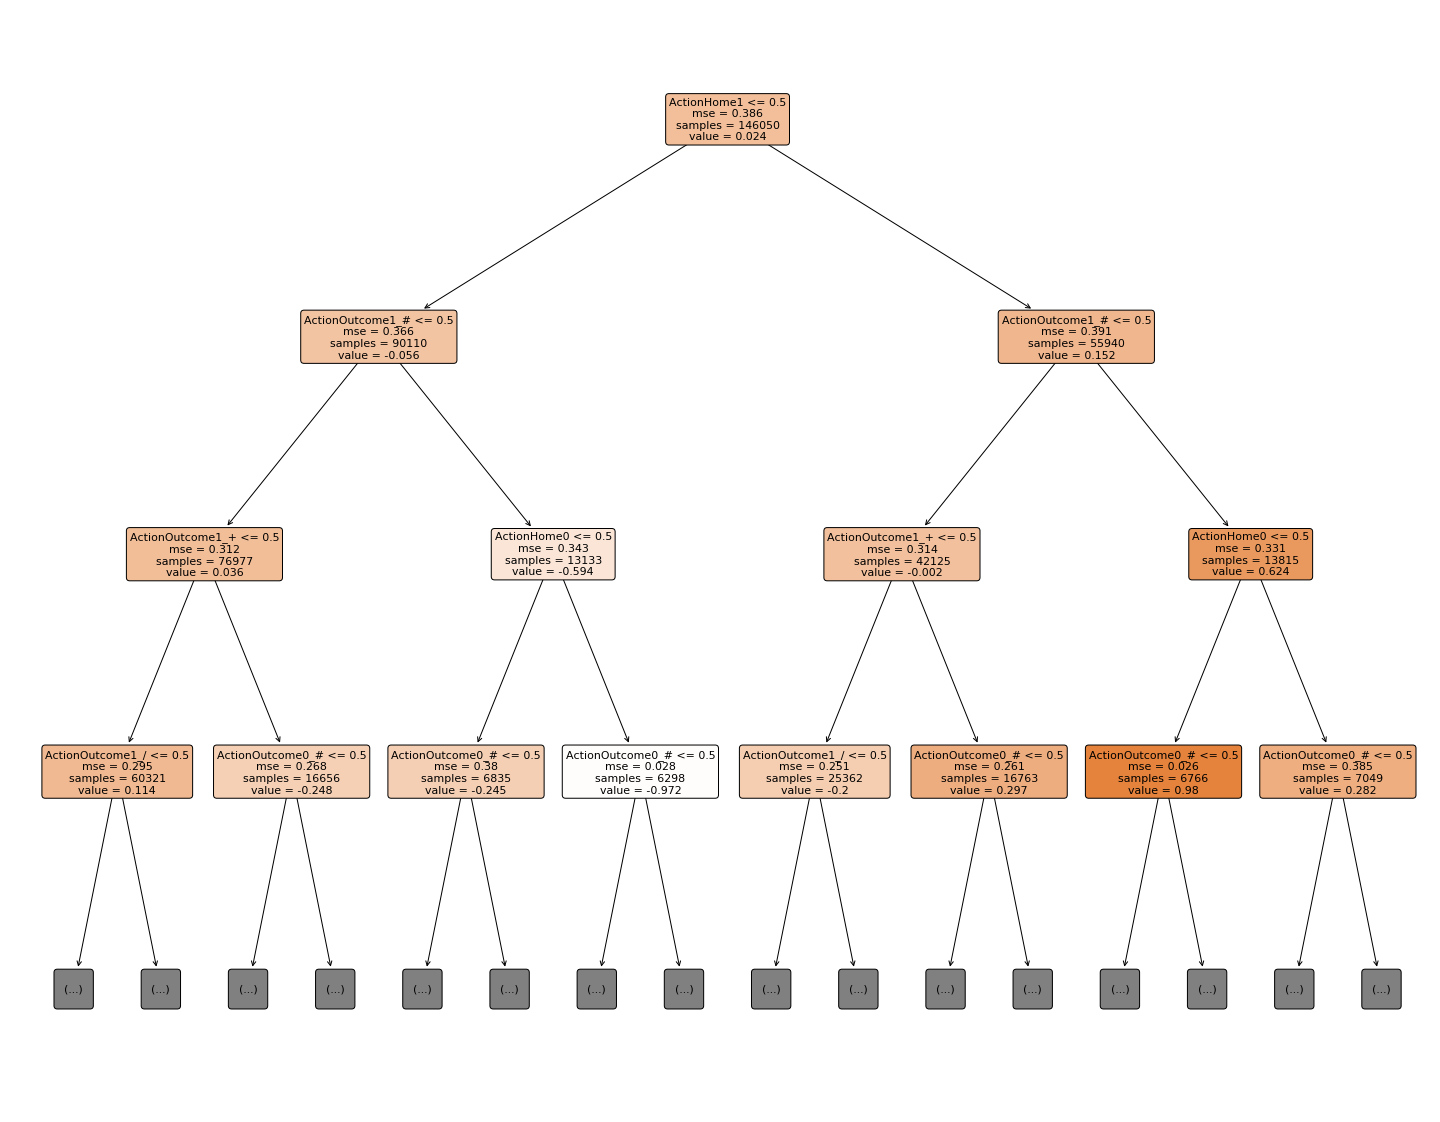

In [60]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25,20))
plot_tree(clf, feature_names=X.columns, filled=True, rounded=True, fontsize=11, max_depth=3)
plt.show()

In [59]:
class_nn = np.sign(q_values)
class_nn[class_nn==0] = 1

class_tree = np.sign(q_tree)
class_tree[class_tree==0] = 1

class_regr = np.sign(y_regr)
class_regr[class_regr==0] = 1

class_mimic = np.sign(y_mimic)
class_mimic[class_mimic==0] = 1

print('Accuracy for NN: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_nn)))
print('Accuracy for Classifier Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_tree)))
print('Accuracy for Regressor Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_regr)))
print('Accuracy for Mimic Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_mimic)))

#print('Mean squared error for Mimic Tree: %.3f' % (metrics.accuracy_score(true_prob,mimic_prob)))
#print('Mean squared error for Regressor Tree: %.3f' % (metrics.accuracy_score(true_prob,regr_prob)))

Accuracy for NN: 0.753
Accuracy for Classifier Tree: 0.749
Accuracy for Regressor Tree: 0.749
Accuracy for Mimic Tree: 0.751


In [58]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor(max_depth=12, min_samples_split=200)
# Train Decision Tree regressor on NN Q values
clf = clf.fit(X,y_q)
y_mimic = clf.predict(X)
mimic_prob = np.zeros([len(vb),2])
mimic_prob[:,0] = .5-.5*y_mimic
mimic_prob[:,1] = 1 - mimic_prob[:,0]
print('Cross entropy loss for Mimic Tree: %.3f' % (metrics.log_loss(true_prob,mimic_prob,eps=1e-6)))

Cross entropy loss for Mimic Tree: 0.433


In [37]:
print(true_prob)
print(mimic_prob)
print(metrics.mean_squared_error(true_prob[:,0],mimic_prob[:,0]))
class_mimic = np.sign(y_mimic)
class_mimic[class_mimic==0] = 1
print('Accuracy for Mimic Tree: %.3f' % (metrics.accuracy_score(vb.RewardValue,class_mimic)))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0.52796625 0.47203375]
 [0.52796625 0.47203375]
 [0.42375653 0.57624347]
 ...
 [0.42375653 0.57624347]
 [0.52796625 0.47203375]
 [0.52796625 0.47203375]]
0.2582632313324752
Accuracy for Mimic Tree: 0.545


In [49]:
print(mimic_prob)
print(y_mimic)
print(true_prob)

[[0.52796625 0.47203375]
 [0.52796625 0.47203375]
 [0.42375653 0.57624347]
 ...
 [0.42375653 0.57624347]
 [0.52796625 0.47203375]
 [0.52796625 0.47203375]]
[-0.0559325  -0.0559325   0.15248693 ...  0.15248693 -0.0559325
 -0.0559325 ]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [42]:
print(vb.RewardValue)

0         1
1         1
2         1
3         1
4         1
5        -1
6        -1
7        -1
8        -1
9        -1
10       -1
11       -1
12        1
13        1
14        1
15        1
16       -1
17       -1
18       -1
19       -1
20       -1
21       -1
22       -1
23        1
24        1
25        1
26        1
27        1
28        1
29        1
         ..
146020   -1
146021   -1
146022   -1
146023    1
146024   -1
146025    1
146026    1
146027    1
146028    1
146029    1
146030    1
146031    1
146032    1
146033    1
146034    1
146035    1
146036   -1
146037   -1
146038   -1
146039   -1
146040    1
146041    1
146042    1
146043    1
146044    1
146045    1
146046   -1
146047   -1
146048   -1
146049   -1
Name: RewardValue, Length: 146050, dtype: int64
